In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt

In [2]:
EDGES = '../datasets/cora/cora.cites'
FEATURES = '../datasets/cora/cora.content'

In [3]:
# loading edge and feature information to dataframes
edge_index = pd.read_csv(EDGES, sep = '\t', names = ['source', 'target'], header = None)
feature_mat = pd.read_csv(FEATURES, sep = '\t', header = None)

In [4]:
paper_ids = sorted(set(edge_index.to_numpy().flatten()))
total_papers = len(paper_ids)

# mapping paper ids to new ids starting from 0
node_map = dict(zip(paper_ids, range(total_papers)))
edge_index['source'] = edge_index['source'].map(node_map)
edge_index['target'] = edge_index['target'].map(node_map)
feature_mat[0] = feature_mat[0].map(node_map)
feature_mat = feature_mat.sort_values(by=[0])

In [5]:
feature_mat

0     1     2     3     4     5     6     7     8     9     ...  1425  \
163      0     0     0     0     0     0     0     0     0     0  ...     0   
168      1     0     0     0     0     0     0     0     0     0  ...     0   
552      2     0     0     0     0     0     0     0     1     0  ...     0   
1459     3     0     0     0     0     0     0     0     0     0  ...     0   
554      4     0     1     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
147   2703     0     0     0     0     0     0     0     0     0  ...     0   
1953  2704     0     0     0     0     0     0     0     0     0  ...     0   
1955  2705     0     0     0     0     0     0     0     0     0  ...     0   
1956  2706     0     0     0     0     0     0     0     0     0  ...     0   
1686  2707     0     0     0     0     0     0     0     0     0  ...     0   

      1426  1427  1428  1429  1430  1431  1432  1433                    1434  
163      0     0     0     0     0     0     0     0      Genetic_Algorithms  
168      0     0     0     0     0     0     0     0      Genetic_Algorithms  
552      0     0     0     0     0     0     0     0  Reinforcement_Learning  
1459     0     0     0     0     0     0     0     0  Reinforcement_Learning  
554      0     0     0     0     0     0     0     0  Reinforcement_Learning  
...    ...   ...   ...   ...   ...   ...   ...   ...                     ...  
147      0     0     0     0     0     0     0     0              Case_Based  
1953     0     0     0     0     0     0     0     0         Neural_Networks  
1955     0     0     0     0     0     0     0     0           Rule_Learning  
1956     0     0     0     0     0     0     0     0           Rule_Learning  
1686     0     0     0     0     0     0     0     0           Rule_Learning  

[2708 rows x 1435 columns]

In [288]:
# color map corresponding to 7 classes
colors = ['red', 'blue', 'green', 'orange', 'yellow', 'pink', 'gray']
color_map = dict(zip(sorted(feature_mat[1434].unique()), colors))

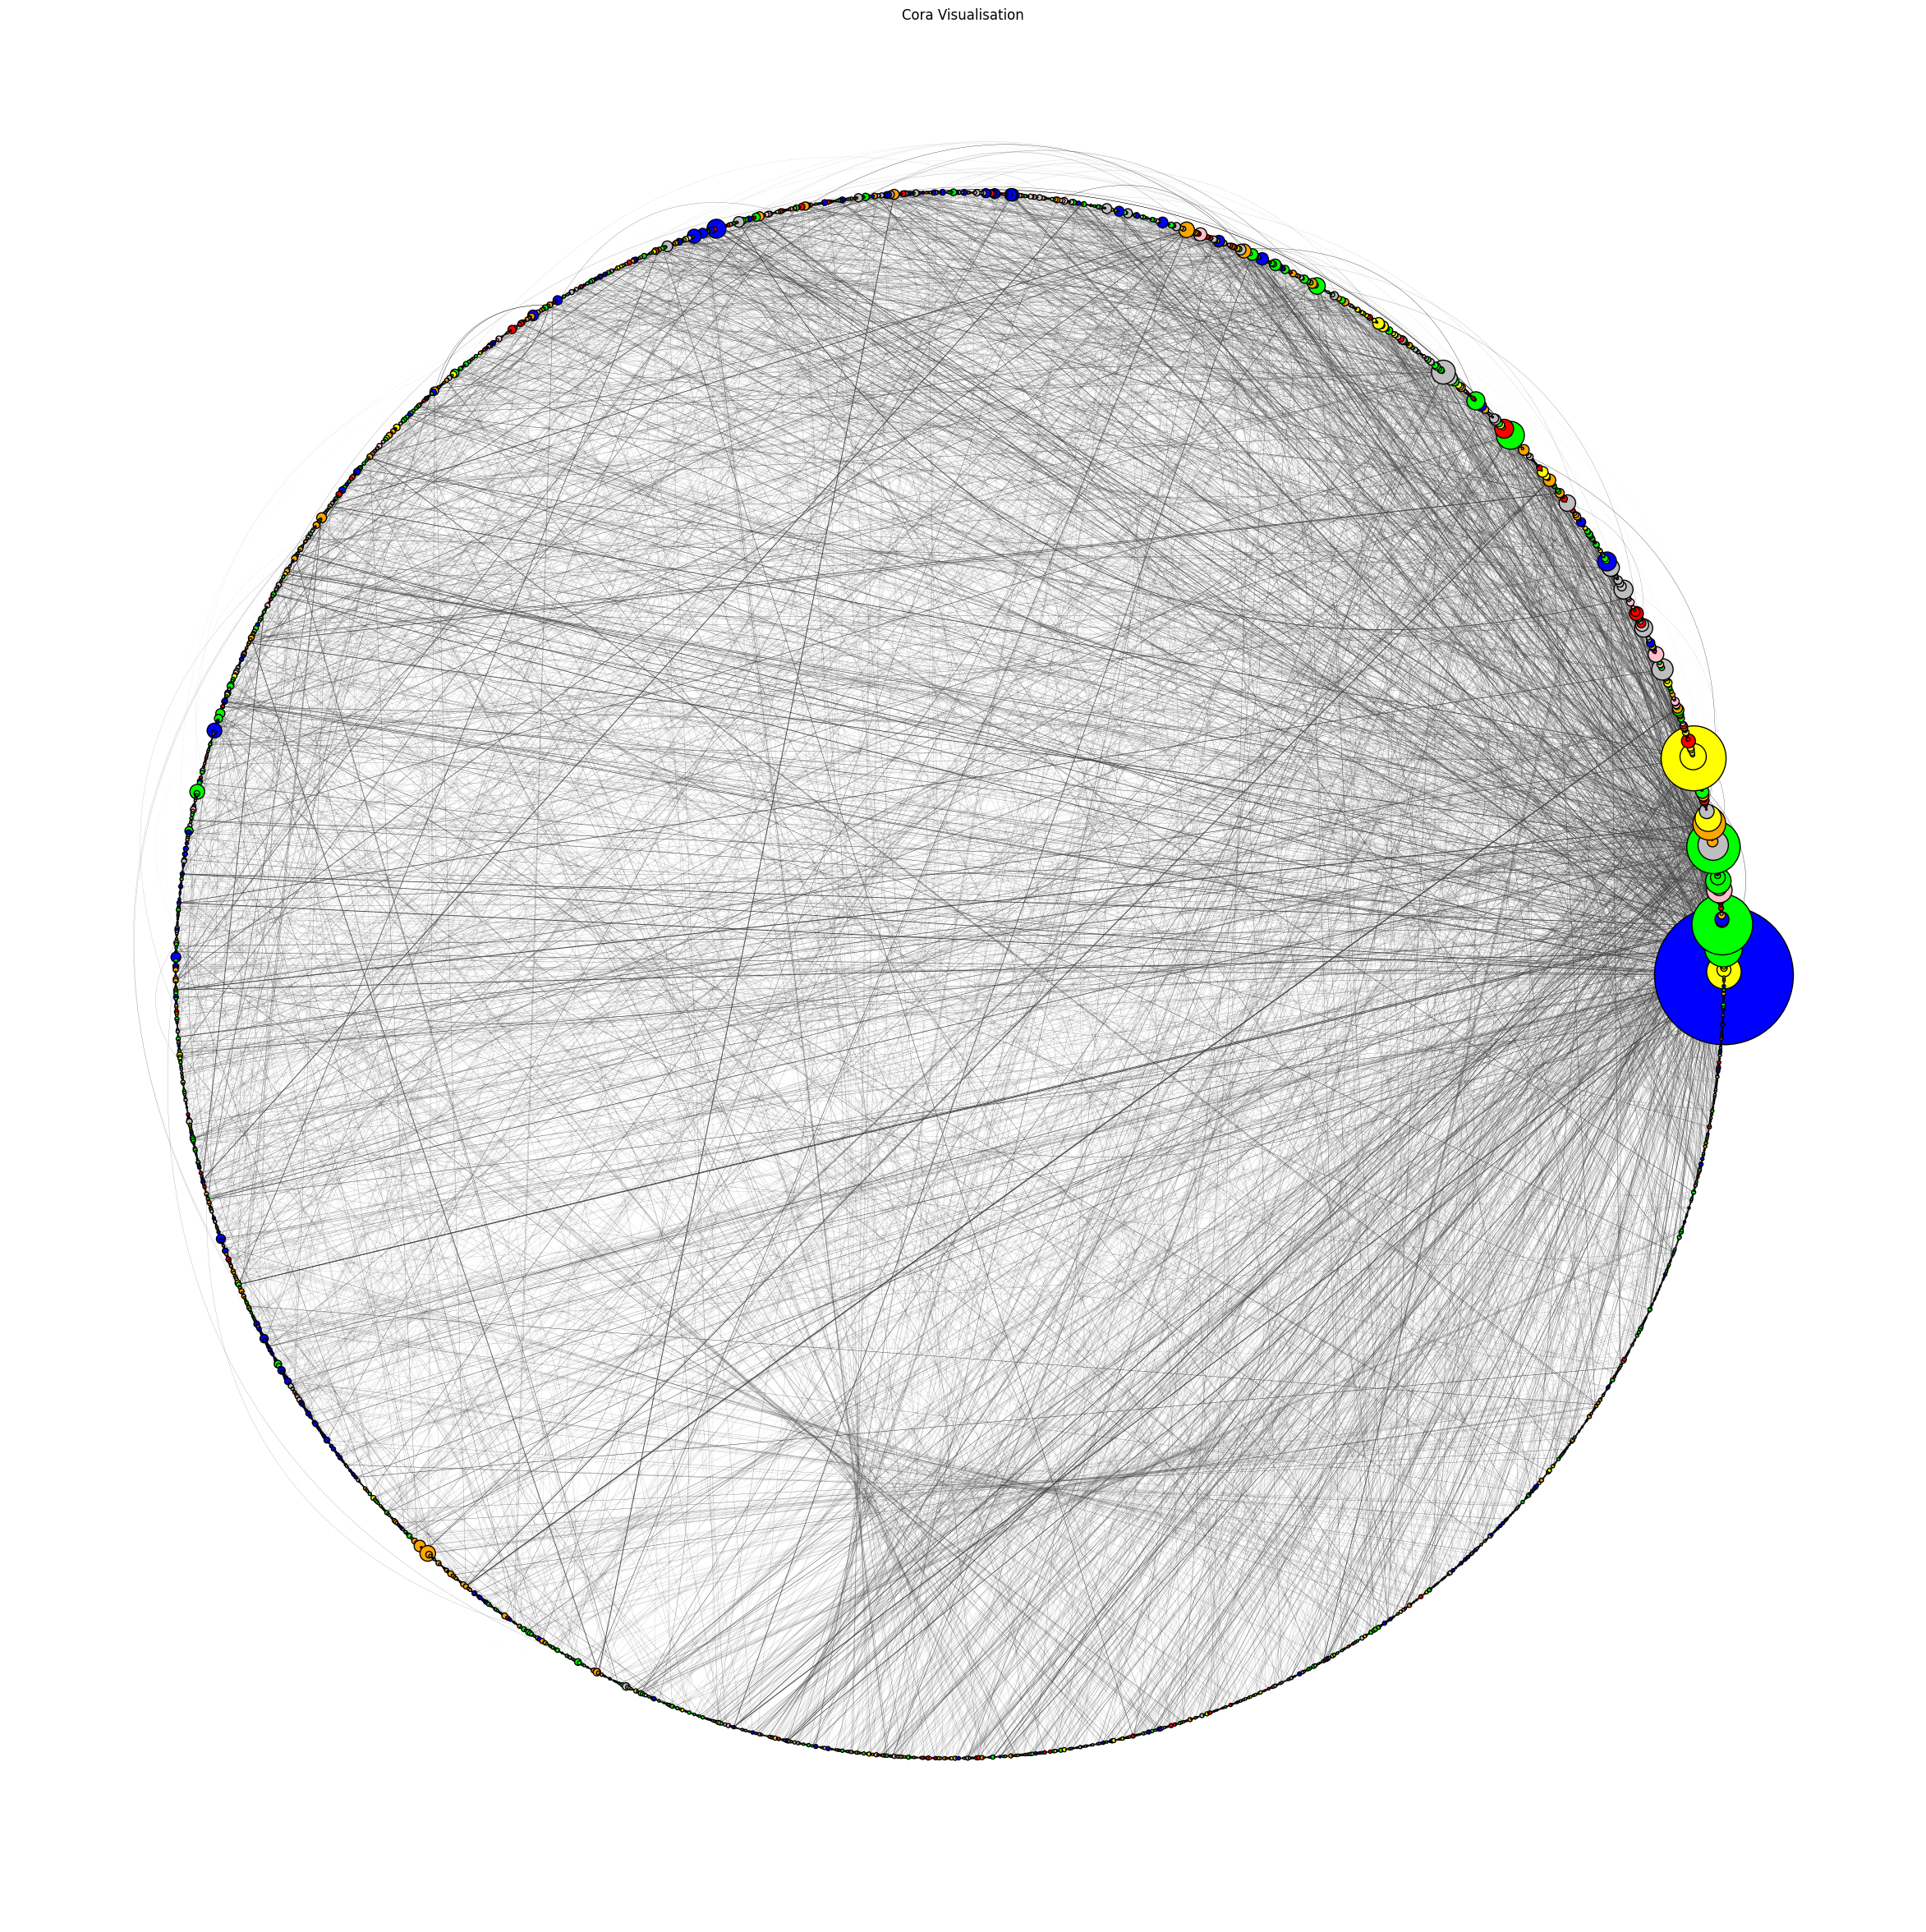

In [289]:
n_vertices = feature_mat.shape[0]
edges = [tuple(row) for row in edge_index.itertuples(index=False)]
g = ig.Graph(n_vertices, edges)
edge_weights_raw = np.clip(np.log(np.asarray(g.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]

fig, ax = plt.subplots(figsize=(30, 30))
ig.plot(
    g,
    target=ax,
    layout='circle',
    vertex_color = [color_map[genre] for genre in feature_mat[1434].tolist()],
    vertex_size = [deg for deg in g.degree()],
    edge_width = edge_weights
)
plt.title('Cora Visualisation')
plt.show()

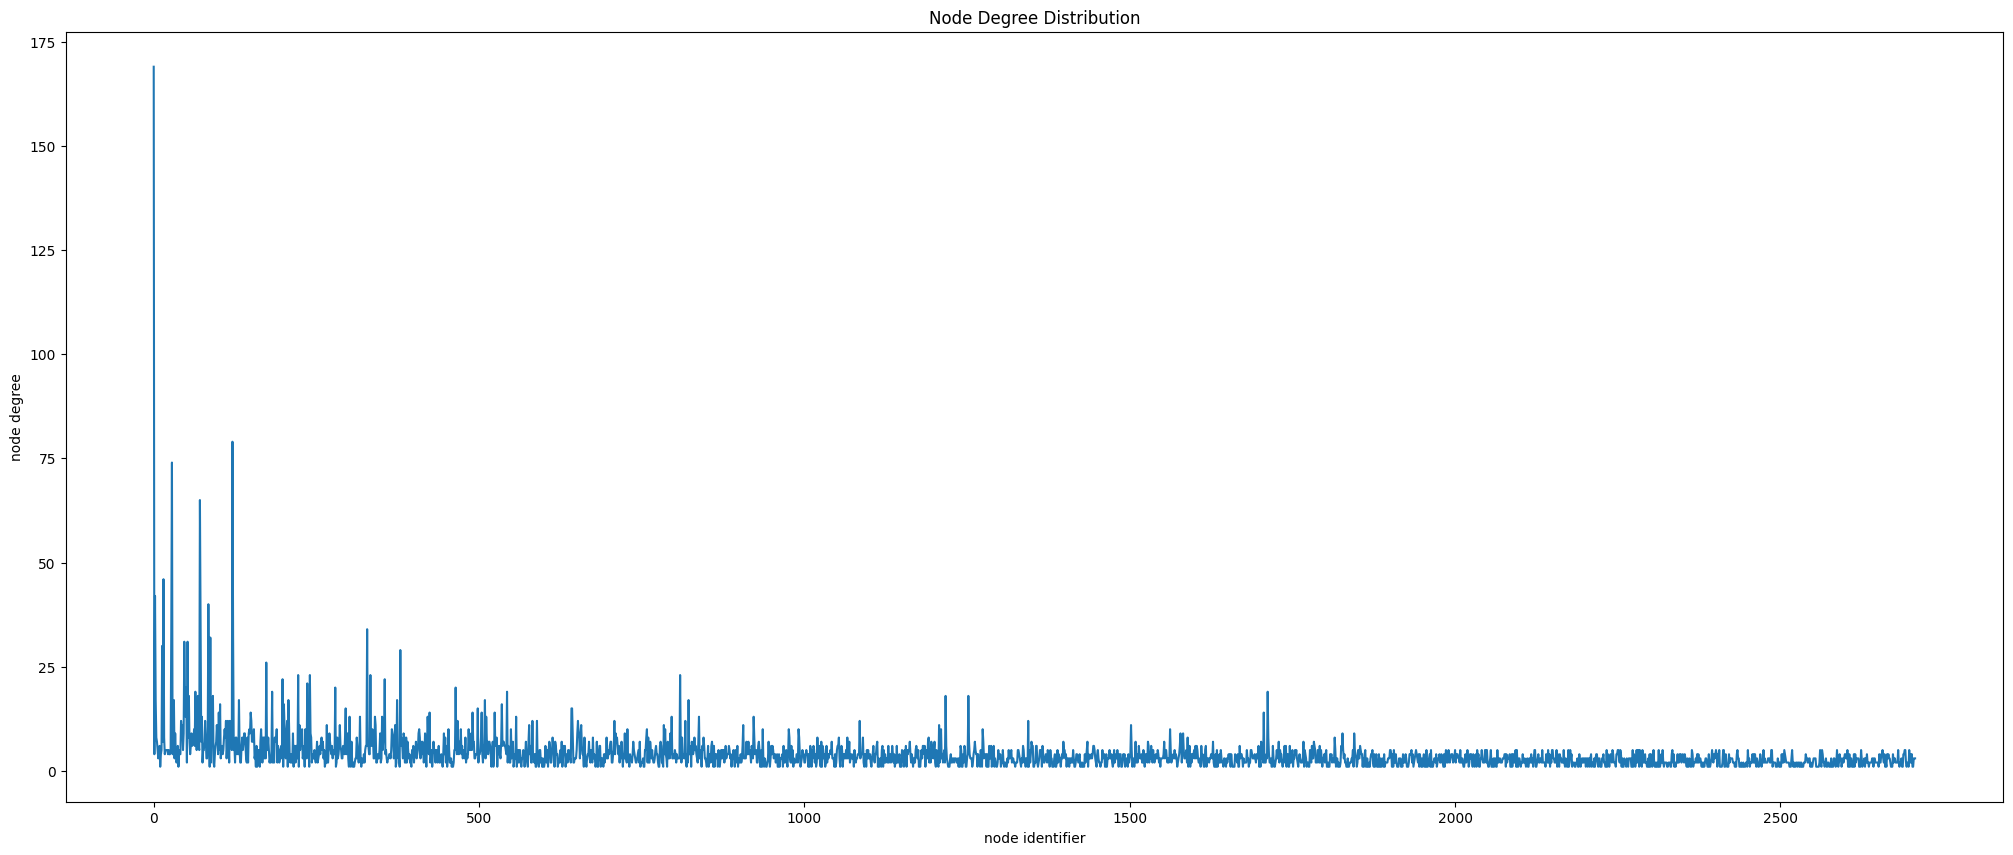

In [290]:
fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel('node identifier')
plt.ylabel('node degree')
plt.title('Node Degree Distribution')
_ = plt.plot(g.degree())

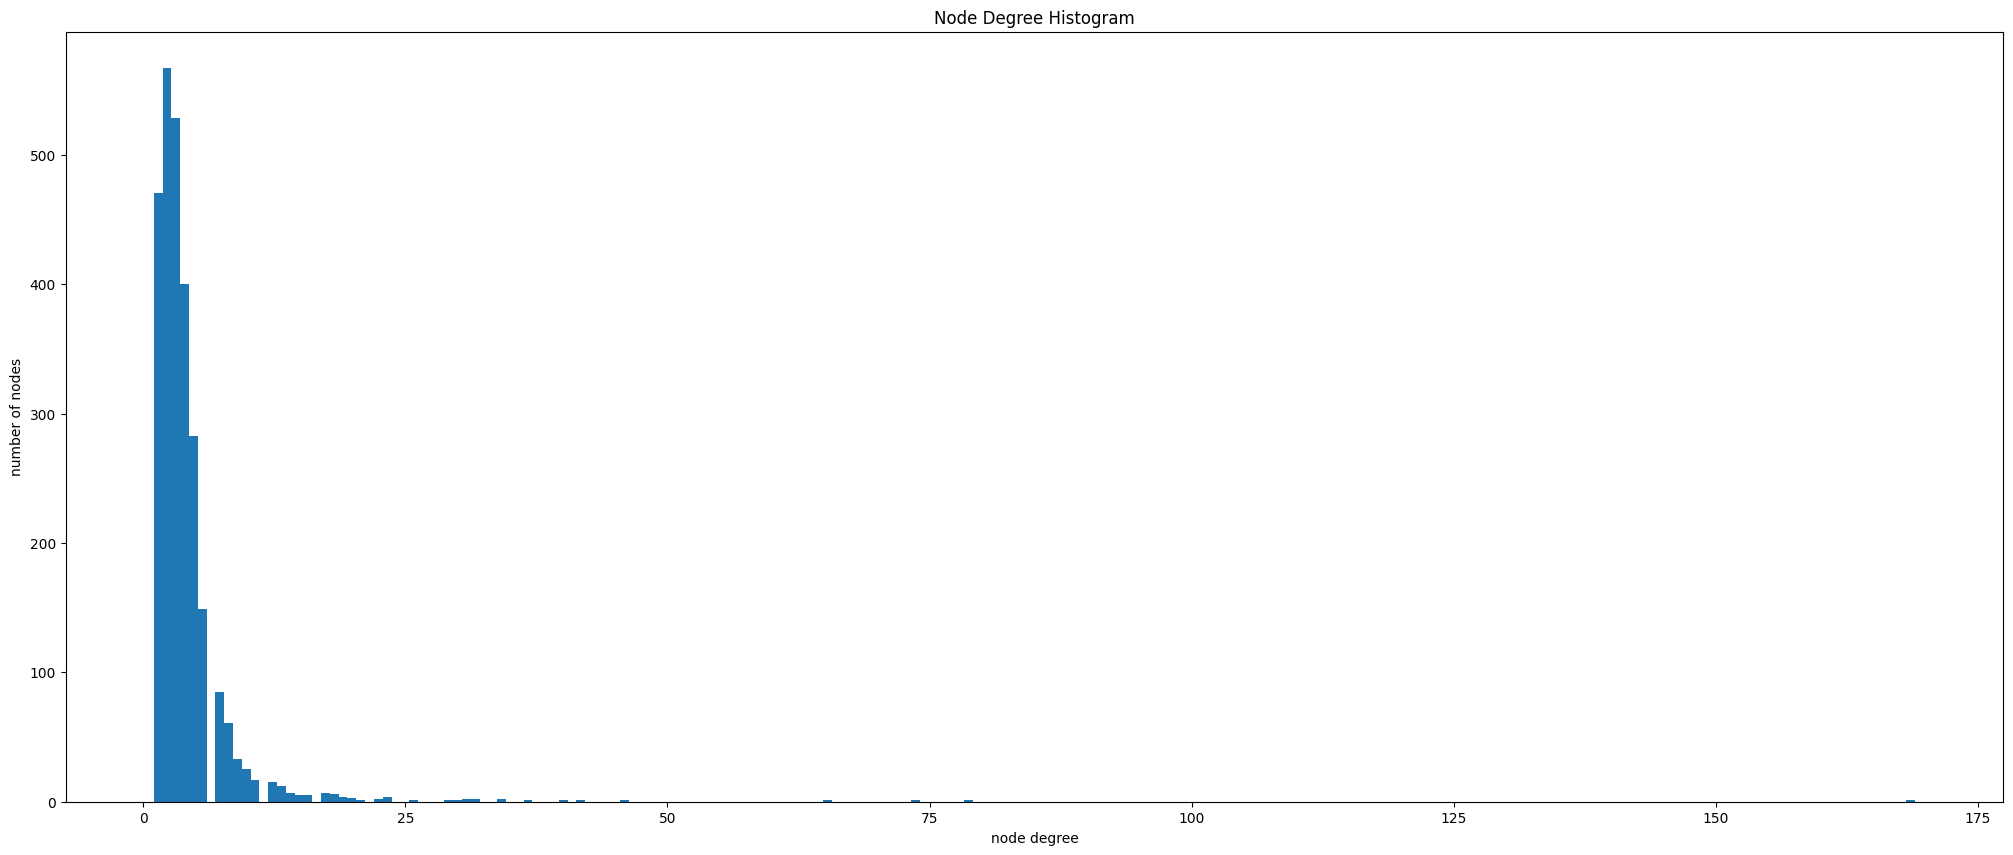

In [291]:
fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel('node degree')
plt.ylabel('number of nodes')
plt.title('Node Degree Histogram')
_ = plt.hist(g.degree(), bins = 200)

In [292]:
# self loops and missing symmetric edges
sources = []
targets = []

for idx, row in edge_index.iterrows():
    s = row['source']
    t = row['target']
    if edge_index[(edge_index.source == t) & (edge_index.target == s)].empty:
        targets.append(s)
        sources.append(t)

sources.extend(list(range(n_vertices)))
targets.extend(list(range(n_vertices)))
new_edges = pd.DataFrame({'source': sources, 'target': targets})
edge_index = pd.concat([edge_index, new_edges], ignore_index=True)

In [293]:
# normalise feature matrix
features = feature_mat[list(range(1, 1434))].values
features_norm = features / np.expand_dims(features.sum(-1), -1)

In [294]:
print('total nodes: ', n_vertices)
print('total edges: ', edge_index.shape[0])
print('features / node: ', features_norm.shape[1])
print('unique node labels: ', feature_mat[1434].unique())

total nodes:  2708
total edges:  13264
features / node:  1433
unique node labels:  ['Genetic_Algorithms' 'Reinforcement_Learning' 'Theory' 'Rule_Learning'
 'Case_Based' 'Probabilistic_Methods' 'Neural_Networks']


In [295]:
cora_target_loc = '../datasets/cora_preprocessed'
if not os.path.exists(cora_target_loc):
    os.mkdir(cora_target_loc)

with open(f'{cora_target_loc}/cora_edge_index.npy', 'wb') as f:
    np.save(f, edge_index.values)
    
with open(f'{cora_target_loc}/cora_features.npy', 'wb') as f:
    np.save(f, features_norm)
    
with open(f'{cora_target_loc}/cora_labels.npy', 'wb') as f:
    np.save(f, feature_mat[1434].values)